In [14]:
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
%pylab inline --no-import-all

file = "/storage/experiments/2021/0807_bourka_sobeslav/slavia/csv/RigolDS3.csv"



Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_table(file, sep=',', header=0)

In [7]:
df['time']=df.index*8e-9

In [10]:
df.set_index('time', inplace=True)

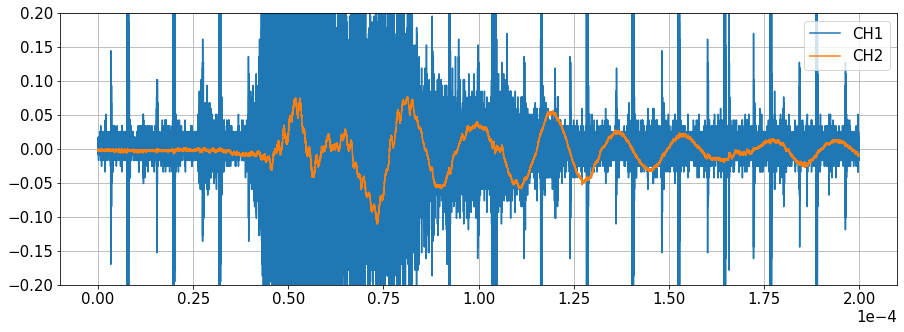

In [30]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.plot(df['CH1(V)'], label='CH1')
plt.plot(df['CH2(V)'], label='CH2')
plt.ylim(-0.2,0.2)
plt.legend()
plt.grid()

In [33]:
cols_to_keep = ['CH1(V)', 'CH1(V)']
df.loc[:, cols_to_keep].to_hdf(file+'.hdf','df', mode='w')

ValueError: Columns index has to be unique for fixed format